In [9]:
import os
import logging
import sys
import contexttimer

import numpy as np
if os.path.basename(os.getcwd()) != 'runlmc':
    os.chdir('..')
sys.path.append('benchmarks/benchlib')
from standard_tester import foreign_exchange_2007, smse, nlpd, cogp_fx2007, statprintlist

from runlmc.models.lmc import LMC, _LOG
from runlmc.kern.rbf import RBF
from runlmc.models.optimization import AdaDelta
from runlmc.models.gpy_lmc import GPyLMC

%matplotlib inline 
import matplotlib.pyplot as plt

logging.getLogger().addHandler(logging.StreamHandler())
_LOG.setLevel(logging.INFO)

In [2]:
# Nguyen 2014 COGP uses Q=2 R=1, but that is not LMC
# Álvarez and Lawrence 2010 Convolved GP has R=4, sort of.
# Álvarez and Lawrence 2010 find that vanilla LMC works best with Q=1 R=2
# that is what we use here
ks = [RBF(name='rbf0')]
ranks = [2]
# the columns with nonzero test holdout are in test_fx
xss, yss, test_xss, test_yss, test_fx, cols = foreign_exchange_2007()

In [3]:
np.random.seed(1234)
lmc = LMC(xss, yss, kernels=ks, ranks=ranks)
opt = AdaDelta(verbosity=20, min_grad_ratio=0.2)
with contexttimer.Timer() as t:
    lmc.optimize(optimizer=opt)
pred_yss, pred_vss = lmc.predict(test_xss)
llgp_time = t.elapsed
llgp_smse = smse(test_yss, pred_yss, yss)
llgp_nlpd = nlpd(test_yss, pred_yss, pred_vss)
print('time', llgp_time, 'smse', llgp_smse, 'nlpd', llgp_nlpd)

LMC lmc generating inducing grid n = 3054
LMC lmc grid (n = 3054, m = 238) complete, 
LMC lmc fully initialized
Optimization (53 hyperparams) starting with 11 workers


starting adadelta {'step_rate': 1, 'decay': 0.9, 'momentum': 0.5, 'offset': 0.0001, 'max_it': 100, 'verbosity': 20, 'min_grad_ratio': 0.2, 'roll': 1, 'permitted_drops': 5, 'callback': <function AdaDelta.noop at 0x7fe104530c80>}
iteration        5 grad norm 5.7016e+02
iteration       10 grad norm 6.5188e+02
iteration       15 grad norm 2.1134e+02
iteration       20 grad norm 2.7247e+02
iteration       25 grad norm 1.8088e+02
iteration       30 grad norm 9.4312e+01
finished adadelta optimization
            31 iterations
    5.9952e+01 final grad norm
    5.9952e+01 final MA(1) grad norm
    6.9672e+02 max MA(1) grad norm
    norm used inf


Using 80 processors for 150 on-the-fly variance predictions


time 55.36815444380045 smse 0.212380224141 nlpd -3.62975893015


In [12]:
# 1 run only, 100 inducing points, as in the paper
stats, cogp_mu, cogp_var = cogp_fx2007(1, 100)
statsnames = ['time', 'smse', 'nlpd']
print(' '.join(map(' '.join, zip(statsnames, statprintlist(stats)))))

time   298.0601 (    0.0000) smse     0.2771 (    0.0000) nlpd    13.0297 (    0.0000)


In [13]:
all_xs = np.arange(min(xs.min() for xs in xss), max(xs.max() for xs in xss) + 1)
test_ix = {col: list(cols).index(col) for col in test_fx}
pred_xss = [all_xs if col in test_fx else np.array([]) for col in cols]
lmc.prediction = 'exact'
pred_yss, pred_vss = lmc.predict(pred_xss)
pred_yss = {col: ys for col, ys in zip(cols, pred_yss)}
pred_vss = {col: vs for col, vs in zip(cols, pred_vss)}

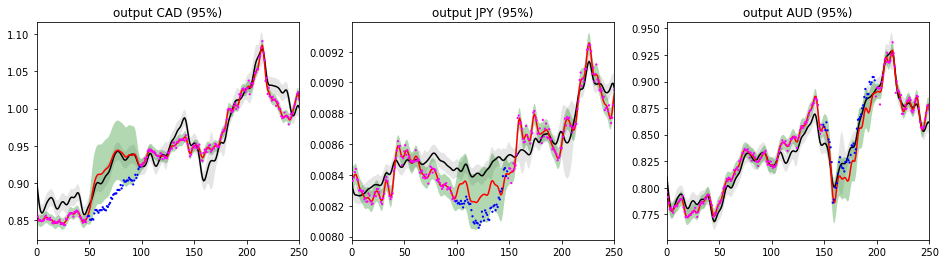

In [14]:
_, axs = plt.subplots(ncols=3, figsize=(16, 4))
for col, ax in zip(test_fx, axs):
    
    # Prediction on entire domain for COGP
    ax.plot(all_xs, cogp_mu[col], c='black', ls='-')
    sd = np.sqrt(cogp_var[col])
    top = cogp_mu[col] + 2 * sd
    bot = cogp_mu[col] - 2 * sd
    ax.fill_between(all_xs, bot, top, facecolor='grey', alpha=0.2)
    
    # Prediction for LLGP
    ax.plot(all_xs, pred_yss[col], c='red')
    sd = np.sqrt(pred_vss[col])
    top = pred_yss[col] + 2 * sd
    bot = pred_yss[col] - 2 * sd
    ax.fill_between(all_xs, bot, top, facecolor='green', alpha=0.3)    
    
    # Actual holdout
    marker_size = 5
    test_xs = test_xss[test_ix[col]]
    test_ys = test_yss[test_ix[col]]
    ax.scatter(test_xs, test_ys, c='blue', edgecolors='none', s=marker_size, zorder=11)
    
    # Rest of image (training)
    rest_xs = xss[test_ix[col]]
    rest_ys = yss[test_ix[col]]
    ax.scatter(rest_xs, rest_ys, c='magenta', edgecolors='none', s=marker_size, zorder=10)
        
    ax.set_xlim([0, 250])
    ax.set_title('output {} (95%)'.format(col))

plt.show()